# Loading and Wrangling Data

Loading in data using the functions that we made:

In [1]:
oneBatch = False

In [2]:
# Run if you want one batch
import data_loading as dt
import os


if oneBatch:
    batchNum = 1
    if os.path.exists(f'batch{batchNum}/part_{batchNum}/'):
        ids, images = dt.importImages(f'batch{batchNum}/part_{batchNum}/')
    else:
        ids, images = dt.loadImageBatch(batchNum)
else:
    batchNums = batchNums = list(range(1,13))
    exist = True
    for batchNum in batchNums:
        if not os.path.exists(f'batch{batchNum}/part_{batchNum}/'):
            exist = False
            break
    if exist:
        ids, images = dt.importImagesBatches(batchNums)
    else:
        ids, images = dt.loadImageBatches(batchNums)

1
2
3
4
5
6
7
8
9
10
11
12


Getting annotations and getting them into the correct order:

In [12]:
print(type(ids))

<class 'numpy.ndarray'>


In [3]:
import pandas as pd
annotations = pd.read_csv("data/annotations.csv")
annotations.head()

,position,image
0,standing,1
1,standing,2
2,standing,3
3,standing,4
4,standing,5


In [4]:
position_maps= {"standing": 0, 
                "takedown1": 1,
                "takedown2": 2,
                "open_guard1": 3,
                "open_guard2": 4,
                "half_guard1": 5,
                "half_guard2": 6,
                "closed_guard1": 7,
                "closed_guard2": 8,
                "5050_guard": 9,
                "mount1": 10,
                "mount2": 11,
                "back1": 12,
                "back2": 13,
                "turtle1": 14,
                "turtle2": 15,               
                "side_control1" : 16,
                "side_control2" : 17}


labels = []
for id in ids:
    labels.append(position_maps[annotations[annotations['image'] == id]['position'].reset_index(drop=True)[0]])

In [ ]:
labels[0:20]

Converting images to tensors:

In [5]:
import torch
import numpy as np

# Converting into torch tensors
for i, img in enumerate(images):
    images[i] = torch.from_numpy(np.array(img))

# Convolutional Neural Net

## Creating Neural Net

In [6]:
# Data argumentation
from torchvision import transforms
data_transforms = transforms.Compose([
        transforms.GaussianBlur(kernel_size=(3,3), sigma=(0.1, 5)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=(0, 180))
])

# CNN
from torch import nn
import torchvision
# class my_net(nn.Modul]e):
    
#     ## Constructor commands
#     def __init__(self):
#         super(my_net, self).__init__()
        
#         ## Define architecture
#         self.conv_stack = nn.Sequential(
#             nn.Conv2d(3,8,3,1),
#             nn.ReLU(),
#             nn.MaxPool2d(2,2),
#             nn.Conv2d(8,16,2,1),
#             nn.ReLU(),
#             nn.MaxPool2d(2,2),
#             nn.Flatten(),
#             nn.Linear(3600, 200),
#             nn.ReLU(),
#             nn.Linear(200, 18)
#         )
    
#     ## Function to generate predictions
#     def forward(self, x):
#         scores = self.conv_stack(x)
#         return scores


# Transfer Learnin
regnet_weights = torchvision.models.RegNet_X_400MF_Weights.IMAGENET1K_V2
regnet_model = torchvision.models.regnet_x_400mf(weights = regnet_weights)
torch.manual_seed(7) # For reproduction purposes (should be minor since only the last layers are randomly intialized)


# print(net)
for param in regnet_model.parameters():
    # print(param)
    param.requires_grad = True
# print(net)
regnet_model.classifier = torch.nn.Sequential( 
    torch.nn.Linear(in_features=400, out_features=18, bias=True))
# print(regnet_model.classifier[0].parameters())
for param in regnet_model.classifier[0].parameters():
    print(param)
    param.requires_grad = True

net = regnet_model

lrate = 0.001
optimizer = torch.optim.Adam(net.parameters(), lr=lrate)

Parameter containing:
tensor([[ 3.4923e-03, -3.0120e-02,  1.5921e-02,  ..., -1.9505e-02,
         -2.0996e-03,  3.3701e-02],
        [ 1.1098e-05,  2.3215e-02,  2.8633e-02,  ...,  1.6767e-02,
         -3.5529e-02,  3.3584e-02],
        [ 1.0616e-02,  3.2056e-02, -4.7595e-02,  ...,  4.7228e-02,
         -1.9226e-03, -1.2700e-02],
        ...,
        [ 1.4529e-02,  2.1283e-02, -2.2148e-02,  ...,  4.8218e-02,
          1.7195e-02, -3.5741e-02],
        [-2.8373e-02, -4.7629e-02,  2.8995e-02,  ...,  8.5895e-04,
         -1.2259e-02,  2.2470e-02],
        [-8.0511e-03, -2.4243e-02,  3.1586e-02,  ..., -4.8393e-03,
         -2.9083e-02,  4.7473e-02]], requires_grad=True)
Parameter containing:
tensor([ 1.0246e-02, -1.1154e-02,  2.9575e-02, -2.9340e-02,  3.4560e-02,
        -4.4570e-02, -3.4269e-02, -1.0834e-03,  3.6994e-02,  2.9584e-02,
         2.2993e-02,  1.9866e-02, -1.8745e-02,  1.9368e-02,  1.8767e-02,
         4.5089e-02, -4.8918e-02,  2.4240e-05], requires_grad=True)


In [ ]:
print(regnet_model.classifier)

## Training Neural Net

Train-test split:

In [7]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(
    images, labels, test_size=0.25, random_state=42)

train_X = torch.from_numpy(train_X)
train_X = torch.movedim(train_X, source=3, destination=1)

test_X = torch.from_numpy(test_X)
test_X = torch.movedim(test_X, source=3, destination=1)

In [8]:
## Hyperparms
epochs = 150
lrate = 0.00001
bsize = 32

## For reproduction purposes 
torch.manual_seed(3)

## Cost Function
cost_fn = nn.CrossEntropyLoss()


## Make DataLoader
from torch.utils.data import DataLoader, TensorDataset
y_tensor = torch.Tensor(train_y)
train_loader = DataLoader(TensorDataset(train_X.type(torch.FloatTensor), 
                        y_tensor.type(torch.LongTensor)), batch_size=bsize)

## Re-run the training loop, notice the new data_transforms() command
track_cost = np.zeros(epochs)
cur_cost = 0.0

# If this does not work, comment this and uncomment the below
for epoch in range(epochs):
    cur_cost = 0.0

    for i, (inputs, labels) in enumerate(train_loader):
        # Transform the input data using our data augmentation strategies
        inputs = data_transforms(inputs)

        # Forward, backward, and optimize
        optimizer.zero_grad()
        outputs = net(inputs)
        cost = cost_fn(outputs, labels)  # CrossEntropyLoss already applies Softmax
        cost.backward()
        optimizer.step()

        cur_cost += cost.item()

    # Store the accumulated cost at each epoch
    track_cost[epoch] = cur_cost
    print(epoch/epochs)
    #print(f"Epoch: {epoch} Cost: {cur_cost}")

# for epoch in range(epochs):
#     cur_cost = 0.0
#     correct = 0.0
    
#     for i, data in enumerate(train_loader, 0):
#         inputs, labels = data
        
#         ## Transform the input data using our data augmentation strategies
#         # inputs = data_transforms(inputs)
        
#         inputs = data_transforms(inputs)
        
#         ## Same as before
#         optimizer.zero_grad()
#         outputs = net(inputs)
#         cost = cost_fn(nn.Softmax(dim=1)(outputs), labels)
#         cost.backward()
#         optimizer.step()
#         cur_cost += cost.item()
    
#     ## Store the accumulated cost at each epoch
#     track_cost[epoch] = cur_cost
#     print("epoch: ", epoch)
#     print("cost: ", cur_cost)
# #     print(f"Epoch: {epoch} Cost: {cur_cost}") ## Uncomment this if you want printed updates
    
    

0.0
0.006666666666666667
0.013333333333333334
0.02
0.02666666666666667
0.03333333333333333
0.04
0.04666666666666667
0.05333333333333334
0.06
0.06666666666666667
0.07333333333333333
0.08
0.08666666666666667
0.09333333333333334
0.1
0.10666666666666667
0.11333333333333333
0.12
0.12666666666666668
0.13333333333333333
0.14
0.14666666666666667
0.15333333333333332
0.16
0.16666666666666666
0.17333333333333334
0.18
0.18666666666666668
0.19333333333333333
0.2
0.20666666666666667
0.21333333333333335
0.22
0.22666666666666666
0.23333333333333334
0.24
0.24666666666666667
0.25333333333333335
0.26
0.26666666666666666
0.2733333333333333
0.28
0.2866666666666667
0.29333333333333333
0.3
0.30666666666666664
0.31333333333333335
0.32
0.32666666666666666
0.3333333333333333
0.34
0.3466666666666667
0.35333333333333333
0.36
0.36666666666666664
0.37333333333333335
0.38
0.38666666666666666
0.3933333333333333
0.4
0.4066666666666667
0.41333333333333333
0.42
0.4266666666666667
0.43333333333333335
0.44
0.4466666666666

Calculating training accuracy:

In [9]:
## Initialize objects for counting correct/total 
correct = 0
total = 0

# Specify no changes to the gradient in the subsequent steps (since we're not using these data for training)
with torch.no_grad():
    for data in train_loader:
        # Current batch of data
        images, labels = data
        
        # pass each batch into the network
        outputs = net(images)
        
        # the class with the maximum score is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        
        # add size of the current batch
        total += labels.size(0)
        
        # add the number of correct predictions in the current batch
        correct += (predicted == labels).sum().item()

## Calculate and print the proportion correct
print(f"Training Accuracy is {correct/total}")

Training Accuracy is 0.9923691816521749


Calculating testing accuracy:

In [10]:

## Combine X and y tensors into a TensorDataset and DataLoader
test_loader = DataLoader(TensorDataset(test_X.type(torch.FloatTensor), 
                        torch.Tensor(test_y).type(torch.LongTensor)), batch_size=bsize)

## Initialize objects for counting correct/total 
correct = 0
total = 0

# Specify no changes to the gradient in the subsequent steps (since we're not using these data for training)
with torch.no_grad():
    for data in test_loader:
        # Current batch of data
        images, labels = data
        
        # pass each batch into the network
        outputs = net(images)
        
        # the class with the maximum score is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        
        # add size of the current batch
        total += labels.size(0)
        
        # add the number of correct predictions in the current batch
        correct += (predicted == labels).sum().item()

## Calculate and print the proportion correct
print(f"Test Accuracy is {correct/total}")

Test Accuracy is 0.9871571615150196


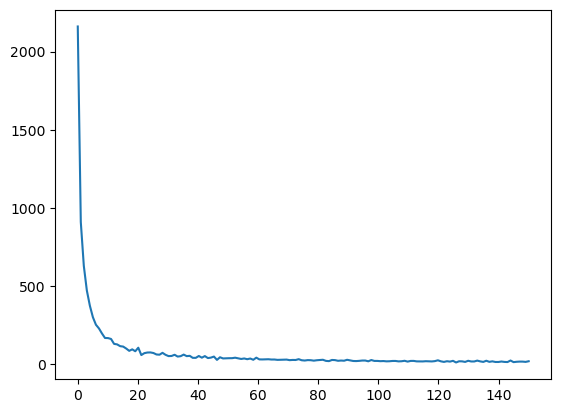

In [11]:
# verifying the convergence of cost
import matplotlib.pyplot as plt
plt.plot(np.linspace(0, epochs, epochs), track_cost)
plt.show()

In [12]:
torch.save(net.state_dict(), 'RegNet_fine_tuning_weights.pth')